# Final Assessment Scratch Pad


## Instructions


1. Please use only this Jupyter notebook to work on your model, and **do not use any extra files**. If you need to define helper classes or functions, feel free to do so in this notebook.
2. This template is intended to be general, but it may not cover every use case. The sections are given so that it will be easier for us to grade your submission. If your specific use case isn't addressed, **you may add new Markdown or code blocks to this notebook**. However, please **don't delete any existing blocks**.
3. If you don't think a particular section of this template is necessary for your work, **you may skip it**. Be sure to explain clearly why you decided to do so.


## Report


##### Overview

Used a convolutional neural network in order

##### 1. Descriptive Analysis
There are labels with nan types. Since Coursemology test set is guaranteed to have labels, just drop these and corresponding X straightway, using code provided in `main.ipynb`

`np.unique(labels, return_counts=True)` gives the remaining 2620 data points, and `images.shape` gives 2620x3x16x16 for 3 channels and 16x16 image size.

`num_nan = np.isnan(images).sum()` guves 19627 nan values and `non_integer_values = images[np.mod(images, 1) != 0]` shows that there are non-integer values. Using indexing and `.sum()` shows among that all the values in X approximately, 0.97% are NaN (a small percentage), and 31% are floats. So floats cannot be rounded to ints.
`np.nanmax()` and `np.nanmin()` show a large range of values, so standardizing will be required.

`plt.imshow` with `np.clip`ed to [0,255], dtype changed to `long` and transposed, images do not appear to be anything.

##### 2. Detection and Handling of Missing Values
y-label NaNs already dropped in Section 1.

`images_nan_dropped = images.copy()[~np.isnan(images).any(axis=(1,2,3))]` shows that every image has nans so they must be filled and not dropped. Fill NaN `np.nanmedian` because `np.nanmean` potentially has issues with numerical stability

##### 3. Detection and Handling of Outliers

Use `np.percentile` to get 25 and 75 percentile for IQR. Boxplot shows that there are a lot of outliers in both tails, but `percent_outliers = num_outside_rgb / img_ravelled.shape[0] * 100` shows only about 2% are outside [0,255] range. 

Empirically, using instead 1.5x IQR or below 1.5x IQR to be threshold for outliers not change the F1 score. Neither did `np.clip([0,255])`.

##### 4. Detection and Handling of Class Imbalance
Class labels of ratios 2392:203:25 (from Section 1). Large class imbalance with the other two classes, which required oversampling.

Because label2 frequency 25 is too few samples to oversample or undersample the other classes, a smote algorithm was used to generate synthetic data. Smote algorithm used K-Nearest-Neighbors and taking the median centroid with added random values as jitter. Oversampled so number of images with labels 1 and labels 2 match the label 0.

Using `class_weights` in ratio 1:10:1000 or 0.01:0.1:1 in `nn.CrossEntropyLoss` did not improve the F1 score empirically

##### 5. Understanding Relationship Between Variables

No obvious relationship between variables when plotted using `np.corrcoef` and `sns.heatmap`. All visually appears to be less than < 0.2 correlation (confirmed with np indexing). So no reason to do anything special with features.


##### 6. Data Visualization

When plotting heatmap after dropping NaN and removing outliers, appearance of colinear variables is likely due to filling up with the median. 

When doing `plt.imshow` again, images still do not resemble anything.

##### 7. General Preprocessing

All preprocessing done in previous steps.

##### 8. Feature Selection

Used PCA with value 256 which explains approximately 90% of the variance. In order to reduce model training time while keeping essential features.

##### 9. Feature Engineering

Used features as-is after PCA because PCA already returns the most important principle components. 

##### 10. Creating Models

Used a Concurrent Neural Network with Convolutional layer and linear layer (similar to problem sets)

`nn.CrossEntropyLoss` because multi-class classification

Empirically `MinMaxScaler()` appeared to do better than `StandardScaler()`.

`CustomTensorDataset` was to used to apply HorizontalRotation, VerticalRotation and colour jitter to transform the dataset, but empircally empirically did not appear to improve F1 score, hence not used in final model.



##### 11. Model Evaluation

Used 5-fold cross validation using `train-test-split` and sklearn `kfold`. Added `nn.Dropout` layers because it appeared to be overfitting training data (>0.2 F1 score larger than other splits).

Used 10-fold-cv on models to be submitted to determine std dev to see which had best F1.

Attempted to use a different Scaler and PCA for each of the 3 colour channel. Did not improve F1 score so removed it.

F1 score also varies widely between runs.

##### 12. Hyperparameters Search

Hyperparameter tuning was done using `ray` `tuner`. Tuning of batch_size, epochs, learning rate was done. Due to large variation in F1 score between runs possibily due to stochasticity, could not reliably determine if certain hyperparameters were more effective than others.

##### Conclusion

**[TODO]**


#### References
smote algorithm referred to ChatGPT https://chat.openai.com/share/9140e304-f05b-4f79-a772-86b041e61683
and https://medium.com/@breya.heysoftware/synthetic-minority-over-sampling-technique-smote-from-scratch-e1167f788434

CustomTensorDataset was not used in final model but is copied directly from https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

seed_worker function (unused) copied directly from https://pytorch.org/docs/stable/notes/randomness.html

Multi-channel PCA referred from here https://towardsdatascience.com/rgb-color-image-compression-using-principal-component-analysis-fce3f48dfdd0 and https://chat.openai.com/share/29961d7d-d6fc-4c45-98e8-dde7b7ed74d1

ray tuning referred from here https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

---


# Workings (Not Graded)

You will do your working below. Note that anything below this section will not be graded, but we might counter-check what you wrote in the report above with your workings to make sure that you actually did what you claimed to have done.


## Import Packages

Here, we import some packages necessary to run this notebook. In addition, you may import other packages as well. Do note that when submitting your model, you may only use packages that are available in Coursemology (see `main.ipynb`).


In [307]:
import pandas as pd
import os
import numpy as np
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Load Dataset

The dataset `data/images.npy` is of size $(N, C, H, W)$, where $N$, $C$, $H$, and $W$ correspond to the number of data, image channels, image width, and image height, respectively.

A code snippet that loads the data is provided below.


### Load Image Data


In [388]:
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    images = data['image']
    labels = data['label']
    
print('Shape:', images.shape)

Shape: (2911, 3, 16, 16)


## Data Exploration & Preparation


### 1. Descriptive Analysis


In [389]:
np.unique(labels, return_counts=True)

# In Coursemology, the test data is guaranteed to have labels
# require oversampling later due to imbalance

(array([ 0.,  1.,  2., nan], dtype=float16),
 array([2392,  203,   25,  291], dtype=int64))

In [390]:
# taken from main.ipynb
# since coursemology guaranteed no missing labels, just drop
nan_indices = np.argwhere(np.isnan(labels)).squeeze()
mask = np.ones(labels.shape, bool)
mask[nan_indices] = False
images = images[mask].copy()
labels = labels[mask].copy()
images.shape

(2620, 3, 16, 16)

In [391]:
np.unique(labels, return_counts=True)

(array([0., 1., 2.], dtype=float16), array([2392,  203,   25], dtype=int64))

In [392]:
np.unique(images, return_counts=True)
num_unique = np.unique(images, return_counts=True)[1].sum()
num_nan = np.isnan(images).sum()
print("num_unique:", num_unique)
print("num_nan:", num_nan)
print("nanmax:", np.nanmax(images))
print("nanmin:", np.nanmin(images))
# print("nanmean:", np.nanmean(images)) # doesn't return anything
# print("nanstd:", np.nanstd(images)) # overflow

non_integer_cond = np.mod(images, 1) != 0
non_integer_values = images[non_integer_cond]
print("non_integer_values:", non_integer_values)
print("non_integer_values.shape:", non_integer_values.shape)
print("% of non_integer_values:", non_integer_values.shape[0] / num_unique * 100)
print("% of nan:", num_nan / images.size * 100)


num_unique: 2012160
num_nan: 19627
nanmax: 10000.0
nanmin: -10000.0
non_integer_values: [  nan   nan   nan ... 72.5  62.25 87.4 ]
non_integer_values.shape: (641102,)
% of non_integer_values: 31.861382792620862
% of nan: 0.975419449745547


In [393]:
from matplotlib import pyplot as plt

# images[0].transpose(1,2,0).astype(np.uint8)
# plt.imshow(images[0].transpose(1,2,0))

# # just in case, but actual values has floats and nans and out of range [0,255]

# def show_images(images, n_row=1, n_col=5, figsize=(12, 12)):
#     _, axs = plt.subplots(n_row, n_col, figsize=figsize)
#     axs = axs.flatten()
#     for img, ax in zip(images, axs):
#         img = img.copy().round().astype(np.uint8)
#         img[np.isnan(img)] = 0
#         ax.imshow(img.transpose(1, 2, 0))
#         ax.axis('off')
#     plt.show()

# show_images(images[:5])


(768, 768)


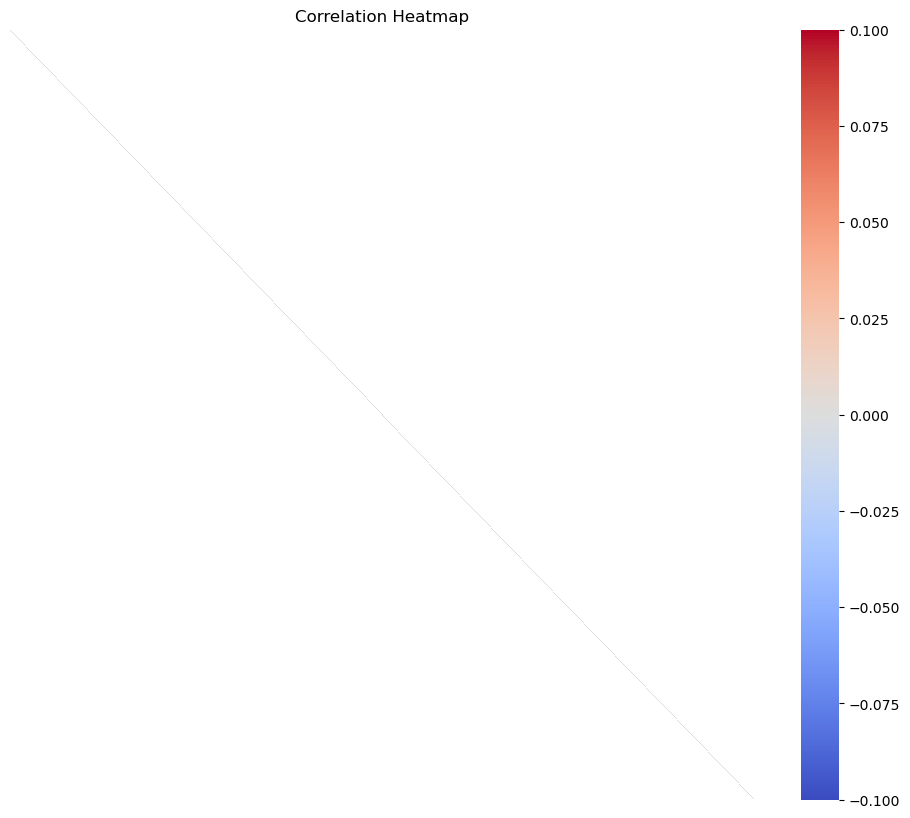

array([], dtype=float64)

In [394]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

n, _, _, _ = images.shape

reshaped_data = images.reshape(n, -1)

# images[np.isnan(images)] = np.nanmedian(images)

correlation_matrix = np.corrcoef(reshaped_data, rowvar=False)
print(correlation_matrix.shape)
np.fill_diagonal(correlation_matrix, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
plt.title('Correlation Heatmap')
plt.show()
correlation_matrix[correlation_matrix > 0.4]

# no obvious correlation

### 2. Detection and Handling of Missing Values


In [395]:
images_nan_dropped = images.copy()[~np.isnan(images).any(axis=(1,2,3))]
labels_nan_dropped = labels.copy()[~np.isnan(images).any(axis=(1,2,3))]
print("images_nan_dropped.shape:", images_nan_dropped.shape)
# ok cannot drop because its in every image

images_nan_dropped.shape: (2, 3, 16, 16)


In [396]:
images_filled = images.copy()

images_filled[np.isnan(images)] = np.nanmedian(images)
# just fill nan with nanmedian, come back to think about it later

### 3. Detection and Handling of Outliers


In [397]:
np.percentile(images_filled, 25)
np.percentile(images_filled, 75)

135.0

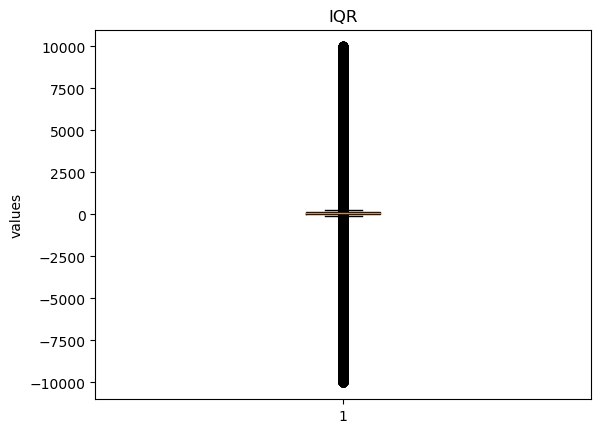

lower_bound: -95.703125
upper_bound: 273.421875
ravelled shape: (2012160,)
outliers shape: (2012160,)
% outliers: 1.9688792143765903
num_outside_rgb: 39831
% outside rgb: 1.9795145515267176


In [317]:
img_ravelled = images_filled.ravel()
Q1 = np.percentile(img_ravelled, 25)
Q3 = np.percentile(img_ravelled, 75)
IQR = Q3 - Q1

plt.boxplot(img_ravelled)
plt.title('IQR')
plt.ylabel("values")
plt.show()

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)

# Identify outliers
outliers = (img_ravelled < lower_bound) | (img_ravelled > upper_bound)

print("ravelled shape:", img_ravelled.shape)
print("outliers shape:", outliers.shape)
num_outliers = np.count_nonzero(outliers)
percent_outliers = num_outliers / img_ravelled.shape[0] * 100
print("% outliers:", percent_outliers)

outside_rgb = (img_ravelled < 0) | (img_ravelled > 255)
num_outside_rgb = np.count_nonzero(outside_rgb)
print("num_outside_rgb:", num_outside_rgb)
percent_outside_rgb = num_outside_rgb / img_ravelled.shape[0] * 100
print("% outside rgb:", percent_outside_rgb)


In [318]:
# images with values outside of IQR
above_upper_bound = np.any(images_filled > upper_bound, axis=(1, 2, 3)) 
below_lower_bound = np.any(images_filled < lower_bound, axis=(1, 2, 3))
above_threshold_count = np.sum(above_upper_bound)
below_threshold_count = np.sum(below_lower_bound)
print("above_threshold_count:", above_threshold_count)
print("below_threshold_count:", below_threshold_count)
# also cannot drop oversampled...

# images with values outside [0,255]
np.any(images_filled < 0, axis=(1, 2, 3)).sum()
np.any(images_filled > 255, axis=(1, 2, 3)).sum()
print("below 0:", np.any(images_filled < 0, axis=(1, 2, 3)).sum())
print("above 255:", np.any(images_filled > 0, axis=(1, 2, 3)).sum())

# just fill with nanmedian...
# to check if it works later
images_filled_outliers = images_filled.copy()

images_filled_outliers[images_filled_outliers < lower_bound] = np.nanmedian(images_filled)
images_filled_outliers[images_filled_outliers > upper_bound] = np.nanmedian(images_filled)

above_threshold_count: 2620
below_threshold_count: 2618
below 0: 2618
above 255: 2620


### 4. Detection and Handling of Class Imbalance


In [319]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [320]:
%%time
%%memit

### adapted from https://chat.openai.com/share/9140e304-f05b-4f79-a772-86b041e61683

from sklearn.neighbors import NearestNeighbors
import numpy as np

def generate_synthetic(X, labels, n_neighbors=3):
    X = X.copy()
    print(X.shape)
    X_where_y0 = X[labels == 0] # majority class
    X_where_y1 = X[labels == 1]
    X_where_y2 = X[labels == 2]
    y0_num = X_where_y0.shape[0]
    y1_num = X_where_y1.shape[0]
    y2_num = X_where_y2.shape[0]

    X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
    X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

    y1_upsample = y0_num - y1_num
    y2_upsample = y0_num - y2_num

    X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
    X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

    X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
    X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])


    X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
    y_oversampled = np.hstack([
      labels,
      np.ones(X_w_y1_synthetic.shape[0]),
      np.full(X_w_y2_synthetic.shape[0], 2)
      ])

    return X_oversampled, y_oversampled


def smote(X, num_oversamples, n_neighbors=5):
    n_samples, n_features = X.shape
    synthetic_samples = np.zeros((num_oversamples, n_features))

    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
    nn.fit(X)

    indices = np.random.randint(0, n_samples, size=num_oversamples)
    samples = X[indices]

    nnres = nn.kneighbors(samples, return_distance=False)

    nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
    nn_samples = X[nn_indices]

    diffs = nn_samples - samples
    synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

    return synthetic_samples.reshape(num_oversamples, *X.shape[1:])

X_synthetic, y_synthetic = generate_synthetic(images_filled_outliers, labels, 5)

(2620, 3, 16, 16)
peak memory: 388.48 MiB, increment: 42.23 MiB
CPU times: total: 594 ms
Wall time: 2.09 s


In [321]:
print("X_synthetic.shape:", X_synthetic.shape)
print("y_synthetic.shape:", y_synthetic.shape)
np.unique(y_synthetic, return_counts=True)

X_synthetic.shape: (7176, 3, 16, 16)
y_synthetic.shape: (7176,)


(array([0., 1., 2.]), array([2392, 2392, 2392], dtype=int64))

### 5. Understanding Relationship Between Variables


(768, 768)


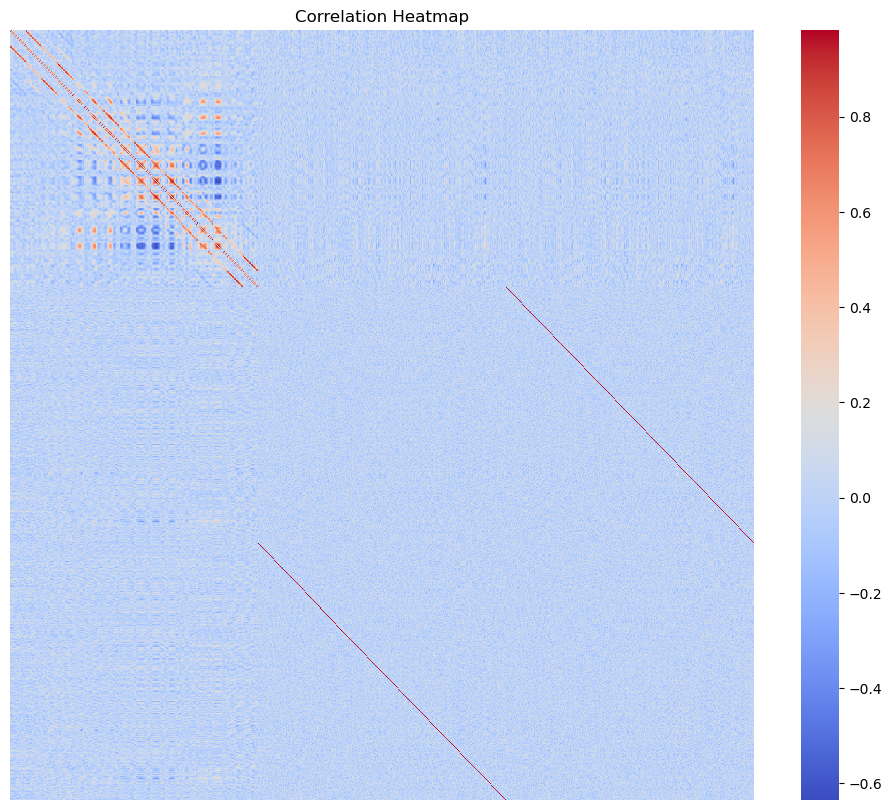

In [322]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is your nx3x16x16 array
n, _, _, _ = X_synthetic.shape

# Reshape the data to make it 2D (n x 3*16*16)
reshaped_data = X_synthetic.reshape(n, -1)

# Compute the correlation matrix
correlation_matrix = np.corrcoef(reshaped_data, rowvar=False)
print(correlation_matrix.shape)
np.fill_diagonal(correlation_matrix, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
plt.title('Correlation Heatmap')
plt.show()

In [323]:
# the correlation is likely to be due to filling outliers and nans with nanmedian. hence unlikely to be useful
# also very few correlations when running at the start

### 6. Data Visualization


In [324]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# 
# from matplotlib import pyplot as plt
# 
# images[0].transpose(1,2,0).astype(np.uint8)
# plt.imshow(images[0].transpose(1,2,0))
# 
# # just in case, but actual values has floats and nans and out of range [0,255]
# 
# def show_images(images, n_row=1, n_col=5, figsize=(12, 12)):
#     _, axs = plt.subplots(n_row, n_col, figsize=figsize)
#     axs = axs.flatten()
#     for img, ax in zip(images, axs):
#         img = img.copy().round().astype(np.uint8)
#         img[np.isnan(img)] = 0
#         ax.imshow(img.transpose(1, 2, 0))
#         ax.axis('off')
#     plt.show()
# 
# show_images(X_synthetic[:5])
# 


## Data Preprocessing


### 7. General Preprocessing


In [325]:
# No categorical variables present

### 8. Feature Selection


In [326]:
%%time
%%memit
from sklearn.decomposition import PCA

pca = PCA(n_components=0.256, random_state=2109, svd_solver='full')
X_synthetic_reshaped = X_synthetic.reshape(X_synthetic.shape[0], -1)
results = pca.fit_transform(X_synthetic_reshaped)

peak memory: 531.40 MiB, increment: 142.68 MiB
CPU times: total: 3.36 s
Wall time: 2 s


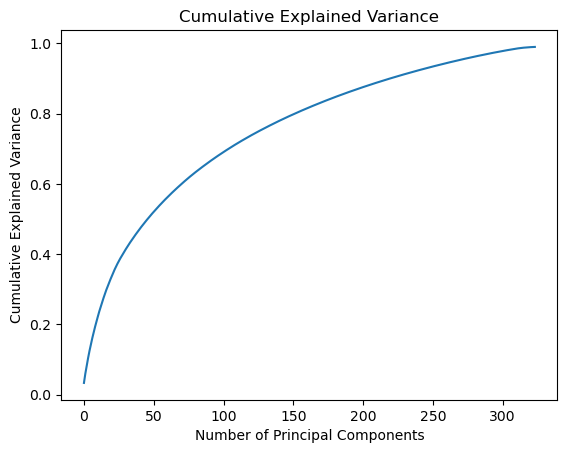

In [327]:

explained_variance_ratios = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratios)
plt.plot(cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### 9. Feature Engineering


## Modeling & Evaluation


### 10. Creating models


In [328]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [1]:
# mutli pca
# doesnt seem to perform significantly better
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
import numpy as np
import random


# def get_augmentations():
#     return transforms.Compose([transforms.RandomHorizontalFlip(),
#                                transforms.RandomVerticalFlip(),
#                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#                                ])


class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    Copied directly from https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """

    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def generate_synthetic(X, labels, n_neighbors=3):
    X = X.copy()
    print(X.shape)
    X_where_y0 = X[labels == 0]  # majority class
    X_where_y1 = X[labels == 1]
    X_where_y2 = X[labels == 2]
    y0_num = X_where_y0.shape[0]
    y1_num = X_where_y1.shape[0]
    y2_num = X_where_y2.shape[0]

    X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
    X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

    y1_upsample = y0_num - y1_num
    y2_upsample = y0_num - y2_num

    X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
    X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

    X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
    X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])

    X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
    y_oversampled = np.hstack([
        labels,
        np.ones(X_w_y1_synthetic.shape[0]),
        np.full(X_w_y2_synthetic.shape[0], 2)
    ])

    return X_oversampled, y_oversampled


def smote(X, num_oversamples, n_neighbors=5, seed=2109):
    np.random.seed(seed)
    n_samples, n_features = X.shape
    synthetic_samples = np.zeros((num_oversamples, n_features))

    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
    nn.fit(X)

    indices = np.random.randint(0, n_samples, size=num_oversamples)
    samples = X[indices]

    nnres = nn.kneighbors(samples, return_distance=False)

    nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
    nn_samples = X[nn_indices]

    diffs = nn_samples - samples
    synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

    return synthetic_samples.reshape(num_oversamples, *X.shape[1:])


def drop_nan_y(X, y):
    nan_indices = np.argwhere(np.isnan(y)).squeeze()
    mask = np.ones(y.shape, bool)
    mask[nan_indices] = False
    X = X[mask]
    y = y[mask]
    return X, y


def clean_x_data(X):
    X[np.isnan(X)] = np.nanmedian(X)
    X[X < 0] = 0
    X[X > 255] = 255
    # lower = np.percentile(X, 25) * 1.15
    # upper = np.percentile(X, 75) * 1.5
    # X[X < lower] = lower
    # X[X > upper] = upper
    return X

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)



# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#         )
#
#         self.fc = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64), 
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, classes)
#         )
#
#
#     def forward(self, x):
#         x = self.network(x)
#         # print(x.shape)
#         x = self.fc(x)
#         return x


class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes=3, drop_prob=0.3, seed=2109):
        super().__init__()
        torch.manual_seed(seed)
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, classes)
        )

    def forward(self, x):
        x = self.network(x)
        # print(x.shape)
        x = self.fc(x)
        return x


class Model:
    """
    This class represents an AI model.
    """

    def __init__(self,
                 batch_size=20,
                 epochs=20,  # epochs seem to get worse after about 10 at num_components=256
                 criterion=nn.CrossEntropyLoss,
                 num_components=256,
                 scaler=MinMaxScaler(),
                 learning_rate=0.0003826645125269827,
                 dropout=0.23535222860200122,
                 seed = 2109
                 ):
        """
        Constructor for Model class.

        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        # TODO: Replace the following code with your own initialization code.
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.optimizer = None
        self.model = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.criterion = criterion()
        self.num_components = num_components
        self.pcas = [PCA(n_components=num_components, svd_solver='full') for _ in range(3)]
        self.scalers = [StandardScaler() for _ in range(3)]


        self.scaler = scaler
        self.dropout = dropout
        self.seed = seed

        self.g = torch.Generator()
        self.g.manual_seed(self.seed)


        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def fit(self, X, y):
        """
        Train the model using the input data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        # TODO: Add your training code.

        self.model = CustomNeuralNetwork(input_size=self.num_components, drop_prob=self.dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        print('start')

        X, y = drop_nan_y(X, y)

        X = clean_x_data(X)

        # print("pre-synthetic")
        X, y = generate_synthetic(X, y, 5)
        # print(y.min())

        # X, X_test, y, y_test = train_test_split(X, y, test_size=100)
        # print(y.min())

        reshaped_channels = [X[:, i, :, :].reshape(X.shape[0], -1) for i in range(X.shape[1])]
        scaled_channels = [self.scalers[i].fit_transform(channel.T).T for i, channel in enumerate(reshaped_channels)]
        transformed_channels = [self.pcas[i].fit_transform(channel) for i, channel in enumerate(scaled_channels)]
        reconstructed_channels = [self.pcas[i].inverse_transform(transformed_channel) for i, transformed_channel in enumerate(transformed_channels)]
        reconstructed_image = np.stack([channel.reshape(X.shape[0], 16, 16) for channel in reconstructed_channels], axis=-1)
        reconstructed_image_input = np.expand_dims(reconstructed_image, axis=0)




        pca_result_tensor = torch.tensor(reconstructed_image_input, dtype=torch.float32)  #.to(self.device)
        labels_tensor = torch.tensor(y, dtype=torch.long)  # .to(self.device)

        # print(y.min())
        # dataset = CustomTensorDataset(tensors=(pca_result_tensor, labels_tensor), transform=get_augmentations())
        dataset = TensorDataset(pca_result_tensor, labels_tensor)
        train_loader = DataLoader(dataset=dataset, 
                                  batch_size=self.batch_size, 
                                  shuffle=True,
                                  num_workers=0,
                                    worker_init_fn=seed_worker,
                                    generator=self.g
                                  )
        # print("pre-epoch")

        epoch_losses = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            # print(f"Epoch {epoch+1}")
            for inputs, labels in train_loader:
                # print(inputs, labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            epoch_losses.append(epoch_loss / len(train_loader))
            print(f"Epoch {epoch + 1} loss: {epoch_losses[-1]}")

        return self

    def predict(self, X):
        """
        Use the trained model to make predictions.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.

        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.

        """
        # TODO: Replace the following code with your own prediction code.
        X = clean_x_data(X)

        X = torch.from_numpy(X).float()
        # X.to(self.device)
        self.model.eval()


        reshaped_channels = [X[:, i, :, :].reshape(X.shape[0], -1) for i in range(X.shape[1])]
        scaled_channels = [self.scalers[i].fit_transform(channel.T).T for i, channel in enumerate(reshaped_channels)]
        transformed_channels = [self.pcas[i].fit_transform(channel) for i, channel in enumerate(scaled_channels)]
        reconstructed_channels = [self.pcas[i].inverse_transform(transformed_channel) for i, transformed_channel in enumerate(transformed_channels)]
        reconstructed_image = np.stack([channel.reshape(X.shape[0], 16, 16) for channel in reconstructed_channels], axis=-1)
        reconstructed_image_input = np.expand_dims(reconstructed_image, axis=0)
# 

        print("fit shape:", reconstructed_image_input.shape)

        original_pca = torch.tensor(reconstructed_image_input, dtype=torch.float32)  #.to(self.device)
        with torch.no_grad():
            outputs = self.model(original_pca)
        return outputs.detach().numpy().argmax(axis=1)


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms

from sklearn.neighbors import NearestNeighbors
import numpy as np
import random



def generate_synthetic(X, labels, n_neighbors=3):
    X = X.copy()
    print(X.shape)
    X_where_y0 = X[labels == 0]  # majority class
    X_where_y1 = X[labels == 1]
    X_where_y2 = X[labels == 2]
    y0_num = X_where_y0.shape[0]
    y1_num = X_where_y1.shape[0]
    y2_num = X_where_y2.shape[0]

    X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
    X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

    y1_upsample = y0_num - y1_num
    y2_upsample = y0_num - y2_num

    X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
    X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

    X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
    X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])

    X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
    y_oversampled = np.hstack([
        labels,
        np.ones(X_w_y1_synthetic.shape[0]),
        np.full(X_w_y2_synthetic.shape[0], 2)
    ])

    return X_oversampled, y_oversampled


def smote(X, num_oversamples, n_neighbors=5, seed=2109):
    np.random.seed(seed)
    n_samples, n_features = X.shape
    synthetic_samples = np.zeros((num_oversamples, n_features))

    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
    nn.fit(X)

    indices = np.random.randint(0, n_samples, size=num_oversamples)
    samples = X[indices]

    nnres = nn.kneighbors(samples, return_distance=False)

    nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
    nn_samples = X[nn_indices]

    diffs = nn_samples - samples
    synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

    return synthetic_samples.reshape(num_oversamples, *X.shape[1:])


def drop_nan_y(X, y):
    nan_indices = np.argwhere(np.isnan(y)).squeeze()
    mask = np.ones(y.shape, bool)
    mask[nan_indices] = False
    X = X[mask]
    y = y[mask]
    return X, y


def clean_x_data(X):
    X[np.isnan(X)] = np.nanmedian(X)
    X[X < 0] = 0
    X[X > 255] = 255
    # lower = np.percentile(X, 25) * 1.15
    # upper = np.percentile(X, 75) * 1.5
    # X[X < lower] = lower
    # X[X > upper] = upper
    return X


# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#         )
#
#         self.fc = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),  # New fully connected layer
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, classes)
#         )
#
#
#     def forward(self, x):
#         x = self.network(x)
#         # print(x.shape)
#         x = self.fc(x)
#         return x


class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes=3, drop_prob=0.3, seed=2109):
        super().__init__()
        torch.manual_seed(seed)
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(drop_prob),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(drop_prob),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, classes)
        )

    def forward(self, x):
        x = self.network(x)
        # print(x.shape)
        x = self.fc(x)
        return x


class Model:
    """
    This class represents an AI model.
    """

    def __init__(self,
                 batch_size=8,
                 epochs=20,  # epochs seem to get worse after about 10 at num_components=256
                 criterion=nn.CrossEntropyLoss,
                 num_components=256,
                 scaler=MinMaxScaler(),
                 learning_rate=0.0003826645125269827,
                 dropout=0.23535222860200122,
                 seed=2109,
                 class_weights=torch.tensor([0.01, 0.1, 1], dtype=torch.float32)
                 ):
        """
        Constructor for Model class.

        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        # TODO: Replace the following code with your own initialization code.
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.optimizer = None
        self.model = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.criterion = criterion(weight=class_weights)
        self.num_components = num_components
        self.pca = PCA(n_components=num_components, svd_solver='full')
        self.scaler = scaler
        self.dropout = dropout
        self.seed = seed



        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def fit(self, X, y):
        """
        Train the model using the input data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        # TODO: Add your training code.

        self.model = CustomNeuralNetwork(input_size=self.num_components, drop_prob=self.dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        print('start')

        X, y = drop_nan_y(X, y)

        X = clean_x_data(X)

        # print("pre-synthetic")
        X, y = generate_synthetic(X, y, 5)
        print(np.unique(y, return_counts=True))
        # print(y.min())

        # X, X_test, y, y_test = train_test_split(X, y, test_size=100)
        # print(y.min())

        # Flatten and normalize the data
        flattened_data = X.reshape(X.shape[0], -1)

        normalized_data = self.scaler.fit_transform(flattened_data)
        # print("pre-pca")
        # print(y.min())
        pca_result = self.pca.fit_transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])

        pca_result_tensor = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
        labels_tensor = torch.tensor(y, dtype=torch.long)  # .to(self.device)

        # print(y.min())
        # dataset = CustomTensorDataset(tensors=(pca_result_tensor, labels_tensor), transform=get_augmentations())
        dataset = TensorDataset(pca_result_tensor, labels_tensor)
        train_loader = DataLoader(dataset=dataset, 
                                  batch_size=self.batch_size, 
                                  shuffle=True,
                                  )
        # print("pre-epoch")

        epoch_losses = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            # print(f"Epoch {epoch+1}")
            for inputs, labels in train_loader:
                # print(inputs, labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            epoch_losses.append(epoch_loss / len(train_loader))
            print(f"Epoch {epoch + 1} loss: {epoch_losses[-1]}")

        return self

    def predict(self, X):
        """
        Use the trained model to make predictions.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.

        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.

        """
        # TODO: Replace the following code with your own prediction code.
        X = clean_x_data(X)

        X = torch.from_numpy(X).float()
        # X.to(self.device)
        self.model.eval()

        flattened_data = X.reshape(X.shape[0], -1)
        normalized_data = self.scaler.transform(flattened_data)
        pca_result = self.pca.transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])

        print("fit shape:", pca_result.shape)

        original_pca = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
        with torch.no_grad():
            outputs = self.model(original_pca)
        return outputs.detach().numpy().argmax(axis=1)


In [2]:
### COURSEMO 0.68
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms

from sklearn.neighbors import NearestNeighbors
import numpy as np


# def get_augmentations():
#     return transforms.Compose([transforms.RandomHorizontalFlip(),
#                                transforms.RandomVerticalFlip(),
#                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#                                ])


class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    Copied directly from https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """

    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def generate_synthetic(X, labels, n_neighbors=3):
    X = X.copy()
    print(X.shape)
    X_where_y0 = X[labels == 0]  # majority class
    X_where_y1 = X[labels == 1]
    X_where_y2 = X[labels == 2]
    y0_num = X_where_y0.shape[0]
    y1_num = X_where_y1.shape[0]
    y2_num = X_where_y2.shape[0]

    X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
    X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

    y1_upsample = y0_num - y1_num
    y2_upsample = y0_num - y2_num

    X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
    X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

    X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
    X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])

    X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
    y_oversampled = np.hstack([
        labels,
        np.ones(X_w_y1_synthetic.shape[0]),
        np.full(X_w_y2_synthetic.shape[0], 2)
    ])

    return X_oversampled, y_oversampled


def smote(X, num_oversamples, n_neighbors=5):
    n_samples, n_features = X.shape
    synthetic_samples = np.zeros((num_oversamples, n_features))

    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
    nn.fit(X)

    indices = np.random.randint(0, n_samples, size=num_oversamples)
    samples = X[indices]

    nnres = nn.kneighbors(samples, return_distance=False)

    nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
    nn_samples = X[nn_indices]

    diffs = nn_samples - samples
    synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

    return synthetic_samples.reshape(num_oversamples, *X.shape[1:])


def drop_nan_y(X, y):
    nan_indices = np.argwhere(np.isnan(y)).squeeze()
    mask = np.ones(y.shape, bool)
    mask[nan_indices] = False
    X = X[mask]
    y = y[mask]
    return X, y


def clean_x_data(X):
    X[np.isnan(X)] = np.nanmedian(X)
    X[X < 0] = 0
    X[X > 255] = 255
    # lower = np.percentile(X, 25) * 1.15
    # upper = np.percentile(X, 75) * 1.5
    # X[X < lower] = lower
    # X[X > upper] = upper
    return X


# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#         )
#
#         self.fc = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),  # New fully connected layer
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, classes)
#         )
#
#
#     def forward(self, x):
#         x = self.network(x)
#         # print(x.shape)
#         x = self.fc(x)
#         return x


class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes=3, drop_prob=0.3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            # nn.Dropout(drop_prob),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, classes)
        )

    def forward(self, x):
        x = self.network(x)
        # print(x.shape)
        x = self.fc(x)
        return x


class Model:
    """
    This class represents an AI model.
    """

    def __init__(self,
                 batch_size=10,
                 epochs=10,  # epochs seem to get worse after about 10 at num_components=256
                 # learning_rate=1e-3,
                 criterion=nn.CrossEntropyLoss,
                 num_components=256,
                 scaler=MinMaxScaler(),
                 learning_rate=1e-3,
                 ):
        """
        Constructor for Model class.

        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        # TODO: Replace the following code with your own initialization code.
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.optimizer = None
        self.model = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.criterion = criterion()
        self.num_components = num_components
        self.pca = PCA(n_components=num_components, svd_solver='full')
        self.scaler = scaler

    def fit(self, X, y):
        """
        Train the model using the input data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        # TODO: Add your training code.

        self.model = CustomNeuralNetwork(input_size=self.num_components)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        print('start')

        X, y = drop_nan_y(X, y)

        X = clean_x_data(X)

        # print("pre-synthetic")
        X, y = generate_synthetic(X, y, 5)
        # print(y.min())

        # X, X_test, y, y_test = train_test_split(X, y, test_size=100)
        # print(y.min())

        # Flatten and normalize the data
        flattened_data = X.reshape(X.shape[0], -1)

        normalized_data = self.scaler.fit_transform(flattened_data)
        # print("pre-pca")
        # print(y.min())
        pca_result = self.pca.fit_transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])

        pca_result_tensor = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
        labels_tensor = torch.tensor(y, dtype=torch.long)  # .to(self.device)

        # print(y.min())
        # dataset = CustomTensorDataset(tensors=(pca_result_tensor, labels_tensor), transform=get_augmentations())
        dataset = TensorDataset(pca_result_tensor, labels_tensor)
        train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
        # print("pre-epoch")

        epoch_losses = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            # print(f"Epoch {epoch+1}")
            for inputs, labels in train_loader:
                # print(inputs, labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            epoch_losses.append(epoch_loss / len(train_loader))
            print(f"Epoch {epoch + 1} loss: {epoch_losses[-1]}")

        return self

    def predict(self, X):
        """
        Use the trained model to make predictions.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.

        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.

        """
        # TODO: Replace the following code with your own prediction code.
        X = clean_x_data(X)

        X = torch.from_numpy(X).float()
        # X.to(self.device)
        self.model.eval()

        flattened_data = X.reshape(X.shape[0], -1)
        normalized_data = self.scaler.transform(flattened_data)
        pca_result = self.pca.transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])

        print("fit shape:", pca_result.shape)

        original_pca = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
        with torch.no_grad():
            outputs = self.model(original_pca)
        return outputs.detach().numpy().argmax(axis=1)


# Import packages
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, \
    mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Load data
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    X = data['image']
    y = data['label']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Filter test data that contains no labels
# In Coursemology, the test data is guaranteed to have labels
nan_indices = np.argwhere(np.isnan(y_test)).squeeze()
mask = np.ones(y_test.shape, bool)
mask[nan_indices] = False
X_test = X_test[mask]
y_test = y_test[mask]

# Train and predict

model = Model()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# N fold cross validation
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    X = data['image']
    y = data['label']

nan_indices = np.argwhere(np.isnan(y)).squeeze()
mask = np.ones(y.shape, bool)
mask[nan_indices] = False
X = X[mask]
y = y[mask]

num_folds = 3

model = Model()
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2109)

f1_scores = []

for train_index, test_index in kf.split(X):
    model.fit(X=X[train_index], y=y[train_index])

    predictions = model.predict(X[test_index])

    score = f1_score(y[test_index], predictions, average='macro')

    f1_scores.append(score)
    print("train_index:", score)

print("F1:", f1_scores)
print("Mean:", np.mean(f1_scores))
print("Std:", np.std(f1_scores))



In [3]:
# #### COURSEMO 0.61
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# 
# 
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# 
# def generate_synthetic(X, labels, n_neighbors=3):
#     X = X.copy()
#     print(X.shape)
#     X_where_y0 = X[labels == 0] # majority class
#     X_where_y1 = X[labels == 1]
#     X_where_y2 = X[labels == 2]
#     y0_num = X_where_y0.shape[0]
#     y1_num = X_where_y1.shape[0]
#     y2_num = X_where_y2.shape[0]
# 
#     X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
#     X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)
# 
#     y1_upsample = y0_num - y1_num
#     y2_upsample = y0_num - y2_num
# 
#     X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
#     X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)
# 
#     X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
#     X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])
# 
# 
#     X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
#     y_oversampled = np.hstack([
#         labels,
#         np.ones(X_w_y1_synthetic.shape[0]),
#         np.full(X_w_y2_synthetic.shape[0], 2)
#     ])
# 
#     return X_oversampled, y_oversampled
# 
# 
# def smote(X, num_oversamples, n_neighbors=5):
#     n_samples, n_features = X.shape
#     synthetic_samples = np.zeros((num_oversamples, n_features))
# 
#     nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
#     nn.fit(X)
# 
#     indices = np.random.randint(0, n_samples, size=num_oversamples)
#     samples = X[indices]
# 
#     nnres = nn.kneighbors(samples, return_distance=False)
# 
#     nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
#     nn_samples = X[nn_indices]
# 
#     diffs = nn_samples - samples
#     synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))
# 
#     return synthetic_samples.reshape(num_oversamples, *X.shape[1:])
# 
# def drop_nan_y(X, y):
#     nan_indices = np.argwhere(np.isnan(y)).squeeze()
#     mask = np.ones(y.shape, bool)
#     mask[nan_indices] = False
#     X = X[mask]
#     y = y[mask]
#     return X, y
# 
# def clean_x_data(X):
#     X[np.isnan(X)] = np.nanmedian(X)
#     X[X < 0] = 0
#     X[X > 255] = 255
#     return X
# 
# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#                 nn.Linear(input_size, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, classes),
#         )
# 
#     def forward(self, x):
#         return self.network(x)
# 
# 
# class Model:
#     """
#     This class represents an AI model.
#     """
# 
#     def __init__(self, 
#                  batch_size=10, 
#                  epochs=3, 
#                  learning_rate=1e-3, 
#                  criterion=nn.CrossEntropyLoss,
#                  num_components = 128,
#                  ):
#         """
#         Constructor for Model class.
#   
#         Parameters
#         ----------
#         self : object
#             The instance of the object passed by Python.
#         """
#         # TODO: Replace the following code with your own initialization code.
#         # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # self.device = torch.device("cpu")
#         self.optimizer = None
#         self.model = None
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.learning_rate = learning_rate
#         
#         self.criterion = criterion()
#         self.num_components = num_components
#         self.pca = PCA(n_components=num_components, svd_solver='full')
#         self.scaler = MinMaxScaler()
#         
#         
# 
#     def fit(self, X, y):
#         """
#         Train the model using the input data.
#         
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Training data.
#         y : ndarray of shape (n_samples,)
#             Target values.
#             
#         Returns
#         -------
#         self : object
#             Returns an instance of the trained model.
#         """
#         # TODO: Add your training code.
# 
#         self.model = CustomNeuralNetwork(input_size=self.num_components)
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
# 
#         print('start')
# 
#         X, y = drop_nan_y(X, y)
# 
#         X = clean_x_data(X)
# 
# 
# 
#         print("pre-synthetic")
#         X, y = generate_synthetic(X, y, 5)
#         # print(y.min())
#         
#         X, X_test, y, y_test = train_test_split(X, y, test_size=100)
#         # print(y.min())
# 
#         # Flatten and normalize the data
#         flattened_data = X.reshape(X.shape[0], -1)
#         
#         normalized_data = self.scaler.fit_transform(flattened_data)
#         # print("pre-pca")
#         # print(y.min())
#         pca_result = self.pca.fit_transform(normalized_data)
# 
#         pca_result_tensor = torch.tensor(pca_result, dtype=torch.float32) #.to(self.device)
#         labels_tensor = torch.tensor(y, dtype=torch.long) # .to(self.device)
# 
#         # print(y.min())
# 
#         dataset = TensorDataset(pca_result_tensor, labels_tensor)
#         train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
#         print("pre-epoch")
# 
#         epoch_losses = []
#         for epoch in range(self.epochs):
#             epoch_loss = 0
#             print(f"Epoch {epoch+1}")
#             for inputs, labels in train_loader:
#                 # print(inputs, labels)
#                 # print("a1")
#                 self.optimizer.zero_grad()
#                 # print("a2")
#                 outputs = self.model(inputs)
#                 # print("a3")
#                 loss = self.criterion(outputs, labels)
#                 # print("a4")
#                 loss.backward()
#                 # print("a5")
#                 self.optimizer.step()
#                 # print("a6")
#                 epoch_loss += loss.item()
#             epoch_losses.append(epoch_loss / len(train_loader))
#             print(f"Epoch {epoch+1} loss: {epoch_losses[-1]}")
#         
#         return self
# 
#     def predict(self, X):
#         """
#         Use the trained model to make predictions.
#         
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Input data.
#             
#         Returns
#         -------
#         ndarray of shape (n_samples,)
#         Predicted target values per element in X.
#            
#         """
#         # TODO: Replace the following code with your own prediction code.
#         X = clean_x_data(X)
#         
#         X = torch.from_numpy(X).float()
#         # X.to(self.device)
#         self.model.eval()
# 
#         flattened_data = X.reshape(X.shape[0], -1)
#         normalized_data = self.scaler.transform(flattened_data)
#         pca_result = self.pca.transform(normalized_data)
# 
#         print("fit shape:", pca_result.shape)
#         
#         pca_result = torch.tensor(pca_result, dtype=torch.float32) #.to(self.device)
#         outputs = self.model(pca_result)
#         return outputs.detach().numpy().argmax(axis=1)
#     

In [4]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split


# from sklearn.neighbors import NearestNeighbors
# import numpy as np

# def generate_synthetic(X, labels, n_neighbors=3):
#     X = X.copy()
#     print(X.shape)
#     X_where_y0 = X[labels == 0] # majority class
#     X_where_y1 = X[labels == 1]
#     X_where_y2 = X[labels == 2]
#     y0_num = X_where_y0.shape[0]
#     y1_num = X_where_y1.shape[0]
#     y2_num = X_where_y2.shape[0]

#     X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
#     X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

#     y1_upsample = y0_num - y1_num
#     y2_upsample = y0_num - y2_num

#     X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
#     X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

#     X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
#     X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])


#     X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
#     y_oversampled = np.hstack([
#         labels,
#         np.ones(X_w_y1_synthetic.shape[0]),
#         np.full(X_w_y2_synthetic.shape[0], 2)
#     ])

#     return X_oversampled, y_oversampled


# def smote(X, num_oversamples, n_neighbors=5):
#     n_samples, n_features = X.shape
#     synthetic_samples = np.zeros((num_oversamples, n_features))

#     nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
#     nn.fit(X)

#     indices = np.random.randint(0, n_samples, size=num_oversamples)
#     samples = X[indices]

#     nnres = nn.kneighbors(samples, return_distance=False)

#     nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
#     nn_samples = X[nn_indices]

#     diffs = nn_samples - samples
#     synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

#     return synthetic_samples.reshape(num_oversamples, *X.shape[1:])

# def drop_nan_y(X, y):
#     nan_indices = np.argwhere(np.isnan(y)).squeeze()
#     mask = np.ones(y.shape, bool)
#     mask[nan_indices] = False
#     X = X[mask]
#     y = y[mask]
#     return X, y

# def clean_x_data(X):
#     X[np.isnan(X)] = np.nanmedian(X)
#     X[X < 0] = 0
#     X[X > 255] = 255
#     return X

# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, classes),
#         )

#     def forward(self, x):
#         return self.network(x)


# class Model:
#     """
#     This class represents an AI model.
#     """

#     def __init__(self,
#                  batch_size=10,
#                  epochs=3,
#                  learning_rate=1e-3,
#                  criterion=nn.CrossEntropyLoss,
#                  num_components = 128,
#                  ):
#         """
#         Constructor for Model class.
  
#         Parameters
#         ----------
#         self : object
#             The instance of the object passed by Python.
#         """
#         # TODO: Replace the following code with your own initialization code.
#         # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # self.device = torch.device("cpu")
#         self.optimizer = None
#         self.model = None
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.learning_rate = learning_rate

#         self.criterion = criterion()
#         self.num_components = num_components
#         self.pca = PCA(n_components=num_components, svd_solver='full')
#         self.scaler = MinMaxScaler()



#     def fit(self, X, y):
#         """
#         Train the model using the input data.
        
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Training data.
#         y : ndarray of shape (n_samples,)
#             Target values.
            
#         Returns
#         -------
#         self : object
#             Returns an instance of the trained model.
#         """
#         # TODO: Add your training code.

#         self.model = CustomNeuralNetwork(input_size=self.num_components)
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

#         print('start')

#         X, y = drop_nan_y(X, y)

#         X = clean_x_data(X)



#         print("pre-synthetic")
#         X, y = generate_synthetic(X, y, 5)
#         # print(y.min())

#         X, X_test, y, y_test = train_test_split(X, y, test_size=100)
#         # print(y.min())

#         # Flatten and normalize the data
#         flattened_data = X.reshape(X.shape[0], -1)

#         normalized_data = self.scaler.fit_transform(flattened_data)
#         # print("pre-pca")
#         # print(y.min())
#         pca_result = self.pca.fit_transform(normalized_data)

#         pca_result_tensor = torch.tensor(pca_result, dtype=torch.float32) #.to(self.device)
#         labels_tensor = torch.tensor(y, dtype=torch.long) # .to(self.device)

#         # print(y.min())

#         dataset = TensorDataset(pca_result_tensor, labels_tensor)
#         train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
#         print("pre-epoch")

#         epoch_losses = []
#         for epoch in range(self.epochs):
#             epoch_loss = 0
#             print(f"Epoch {epoch+1}")
#             for inputs, labels in train_loader:
#                 # print(inputs, labels)
#                 # print("a1")
#                 self.optimizer.zero_grad()
#                 # print("a2")
#                 outputs = self.model(inputs)
#                 # print("a3")
#                 loss = self.criterion(outputs, labels)
#                 # print("a4")
#                 loss.backward()
#                 # print("a5")
#                 self.optimizer.step()
#                 # print("a6")
#                 epoch_loss += loss.item()
#             epoch_losses.append(epoch_loss / len(train_loader))
#             print(f"Epoch {epoch+1} loss: {epoch_losses[-1]}")

#         return self

#     def predict(self, X):
#         """
#         Use the trained model to make predictions.
        
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Input data.
            
#         Returns
#         -------
#         ndarray of shape (n_samples,)
#         Predicted target values per element in X.
           
#         """
#         # TODO: Replace the following code with your own prediction code.
#         X = clean_x_data(X)

#         X = torch.from_numpy(X).float()
#         # X.to(self.device)
#         self.model.eval()

#         flattened_data = X.reshape(X.shape[0], -1)
#         normalized_data = self.scaler.transform(flattened_data)
#         pca_result = self.pca.transform(normalized_data)

#         print("fit shape:", pca_result.shape)

#         pca_result = torch.tensor(pca_result, dtype=torch.float32) #.to(self.device)
#         outputs = self.model(pca_result)
#         return outputs.detach().numpy().argmax(axis=1)


In [5]:
# from torchvision.transforms import transforms
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset, Dataset
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# 
# 
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# 
# def generate_synthetic(X, labels, n_neighbors=3, seed=2109):
#     X = X.copy()
#     print(X.shape)
#     X_where_y0 = X[labels == 0] # majority class
#     X_where_y1 = X[labels == 1]
#     X_where_y2 = X[labels == 2]
#     y0_num = X_where_y0.shape[0]
#     y1_num = X_where_y1.shape[0]
#     y2_num = X_where_y2.shape[0]
# 
#     # flatten X_where_y1 and X_where_y2 for smote
#     X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
#     X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)
# 
#     # number of oversample required
#     y1_upsample = y0_num - y1_num
#     y2_upsample = y0_num - y2_num
# 
#     # generate synthetic data
#     X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors, seed)
#     X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors, seed)
# 
#     # reshape to original shape
#     X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
#     X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])
# 
#     # add back syntehtic data
#     X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
#     y_oversampled = np.hstack([
#         labels,
#         np.ones(X_w_y1_synthetic.shape[0]),
#         np.full(X_w_y2_synthetic.shape[0], 2)
#     ])
# 
#     return X_oversampled, y_oversampled
# 
# 
# def smote(X, num_oversamples, n_neighbors=5, seed=2109):
#     """
#     take 2d X and oversample it to num_oversamples using n_neighbors
#     """
#     rng = np.random.default_rng(seed=2109)
# 
#     n_samples, n_features = X.shape
#     synthetic_samples = np.zeros((num_oversamples, n_features))
# 
#     nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
#     nn.fit(X)
# 
#     # randomly sample from X
#     indices = rng.integers(0, n_samples, size=num_oversamples)
#     samples = X[indices]
# 
#     # find nearest neighbors and randomly sample from
#     nnres = nn.kneighbors(samples, return_distance=False)
#     nn_indices = nnres[np.arange(num_oversamples), rng.integers(0, n_neighbors, size=num_oversamples)]
#     nn_samples = X[nn_indices]
# 
#     diffs = nn_samples - samples
#     synthetic_samples = samples + diffs * rng.random(size=(num_oversamples, 1))
# 
#     return synthetic_samples.reshape(num_oversamples, *X.shape[1:])
# 
# def drop_nan_y(X, y):
#     nan_indices = np.argwhere(np.isnan(y)).squeeze()
#     mask = np.ones(y.shape, bool)
#     mask[nan_indices] = False
#     X = X[mask]
#     y = y[mask]
#     return X, y
# 
# def clean_x_data(X):
#     X[np.isnan(X)] = np.nanmedian(X)
#     X[X < 0] = 0
#     X[X > 255] = 255
#     return X
# 
# def get_augmentations():
#     return transforms.Compose([transforms.RandomHorizontalFlip(),
#                                transforms.RandomVerticalFlip(),
#                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#                                ])
# 
# 
# class CustomTensorDataset(Dataset):
#     """TensorDataset with support of transforms.
#     Copied directly from https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
#     """
#     def __init__(self, tensors, transform=None):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
#         self.tensors = tensors
#         self.transform = transform
# 
#     def __getitem__(self, index):
#         x = self.tensors[0][index]
# 
#         if self.transform:
#             x = self.transform(x)
# 
#         y = self.tensors[1][index]
# 
#         return x, y
# 
#     def __len__(self):
#         return self.tensors[0].size(0)
# 
# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#                 nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#                 nn.MaxPool2d(kernel_size=2, stride=2),
#                 nn.LeakyReLU(),
#                 nn.Dropout(drop_prob),
#                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#                 nn.MaxPool2d(kernel_size=2, stride=2),
#                 nn.LeakyReLU(),
#                 nn.Flatten(),
#                 nn.Linear(32 * 8 * 8, 128),
#                 nn.LeakyReLU(),
#                 nn.Linear(128, classes),
#         )
# 
#     def forward(self, x):
#         return self.network(x)
# 
# 
# class Model:
#     """
#     This class represents an AI model.
#     """
# 
#     def __init__(self, 
#                  batch_size=100, 
#                  epochs=1000, 
#                  learning_rate=1e-3, 
#                  criterion=nn.CrossEntropyLoss,
#                  num_components = 128,
#                  test_size: int | float = 0.1,
#                  n_neighbors: int = 5,
#                  seed = 2109
#                  ):
#         """
#         Constructor for Model class.
#   
#         Parameters
#         ----------
#         self : object
#             The instance of the object passed by Python.
#         batch_size : int
#             The batch size to use for training.
#         epochs : int
#             The number of epochs to train for.
#         learning_rate : float
#             The learning rate to use for training.
#         criterion : nn.Module
#             The loss function to use for training.
#         num_components : int
#             The number of components to use for PCA.
#         test_size : int | float
#             The number of samples or the proportion of samples to use for testing.
#         """
#         # TODO: Replace the following code with your own initialization code.
#         # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # self.device = torch.device("cpu")
#         self.optimizer = None
#         self.model = None
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.learning_rate = learning_rate
#         self.test_size = test_size
#         self.criterion = criterion()
#         self.num_components = num_components
#         self.pcas = [PCA(n_components=num_components, svd_solver='full') for _ in range(3)]
#         self.scalers = [StandardScaler() for _ in range(3)]
#         self.n_neighbors = n_neighbors
#         self.seed = seed
#         
#         
# 
#     def fit(self, X, y):
#         """
#         Train the model using the input data.
#         
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Training data.
#         y : ndarray of shape (n_samples,)
#             Target values.
#             
#         Returns
#         -------
#         self : object
#             Returns an instance of the trained model.
#         """
#         # TODO: Add your training code.
# 
#         self.model = CustomNeuralNetwork(input_size=self.num_components)
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
# 
#         print('start')
# 
#         X, y = drop_nan_y(X, y)
# 
#         X = clean_x_data(X)
# 
#         X, _, y, _ = train_test_split(X, y, test_size=self.test_size)
# 
#         X, y = generate_synthetic(X, y, n_neighbors=self.n_neighbors, seed=self.seed)
#         # print(y.min())
#         
#         
#         # print(y.min())
# 
#         # need to run scaling then PCA on each channel separately
#         reshaped_channels = [X[:, i, :, :].reshape(X.shape[0], -1) for i in range(X.shape[1])]
#         scaled_channels = [self.scalers[i].fit_transform(channel.T).T for i, channel in enumerate(reshaped_channels)]
#         transformed_channels = [self.pcas[i].fit_transform(channel) for i, channel in enumerate(scaled_channels)]
#         reconstructed_channels = [self.pcas[i].inverse_transform(transformed_channel) for i, transformed_channel in enumerate(transformed_channels)]
#         reconstructed_image = np.stack([channel.reshape(16, 16) for channel in reconstructed_channels], axis=-1)
#         reconstructed_image_input = np.expand_dims(reconstructed_image, axis=0)
# 
# 
# 
#         # normalized_data = self.scaler.fit_transform(flattened_data)
#         # print("pre-pca")
#         # print(y.min())
#         # X_scaled = normalized_data.reshape(-1, *X.shape[1:])
#         # pca_result = self.pca.fit_transform(X_scaled)
# 
#         pca_result_tensor = torch.tensor(reconstructed_image_input, dtype=torch.float32) #.to(self.device)
#         labels_tensor = torch.tensor(y, dtype=torch.long) # .to(self.device)
# 
#         # print(y.min())
# 
#         dataset = CustomTensorDataset((pca_result_tensor, labels_tensor), transform=get_augmentations())
#         train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
# 
#         epoch_losses = []
#         for epoch in range(self.epochs):
#             epoch_loss = 0
#             print(f"Epoch {epoch+1}")
#             for inputs, labels in train_loader:
#                 # print(inputs, labels)
#                 # print("a1")
#                 self.optimizer.zero_grad()
#                 # print("a2")
#                 outputs = self.model(inputs)
#                 # print("a3")
#                 loss = self.criterion(outputs, labels)
#                 # print("a4")
#                 loss.backward()
#                 # print("a5")
#                 self.optimizer.step()
#                 # print("a6")
#                 epoch_loss += loss.item()
#             epoch_losses.append(epoch_loss / len(train_loader))
#             print(f"Epoch {epoch+1} loss: {epoch_losses[-1]}")
#         
#         return self
# 
#     def predict(self, X):
#         """
#         Use the trained model to make predictions.
#         
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Input data.
#             
#         Returns
#         -------
#         ndarray of shape (n_samples,)
#         Predicted target values per element in X.
#            
#         """
#         # TODO: Replace the following code with your own prediction code.
#         X = clean_x_data(X)
#         
#         X = torch.from_numpy(X).float()
#         # X.to(self.device)
#         self.model.eval()
# 
#         # flattened_data = X.reshape(X.shape[0], -1)
#         # normalized_data = self.scaler.transform(flattened_data)
#         # X_scaled = normalized_data.reshape(-1, *X.shape[1:])
#         # pca_result = self.pca.transform(normalized_data)
# 
#         reshaped_channels = [X[:, i, :, :].reshape(X.shape[0], -1) for i in range(X.shape[1])]
#         scaled_channels = [self.scalers[i].fit_transform(channel.T).T for i, channel in enumerate(reshaped_channels)]
#         transformed_channels = [self.pcas[i].fit_transform(channel) for i, channel in enumerate(scaled_channels)]
#         reconstructed_channels = [self.pcas[i].inverse_transform(transformed_channel) for i, transformed_channel in enumerate(transformed_channels)]
#         reconstructed_image = np.stack([channel.reshape(16, 16) for channel in reconstructed_channels], axis=-1)
#         reconstructed_image_input = np.expand_dims(reconstructed_image, axis=0)
# 
#         print("fit shape:", pca_result.shape)
#         
#         pca_result = torch.tensor(pca_result, dtype=torch.float32) #.to(self.device)
#         outputs = self.model(pca_result)
#         return outputs.detach().numpy().argmax(axis=1)
#     

In [ ]:
# coursemo 0.63 CNN
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler
# # from sklearn.model_selection import train_test_split
# 
# 
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# 
# 
# def generate_synthetic(X, labels, n_neighbors=3):
#     X = X.copy()
#     print(X.shape)
#     X_where_y0 = X[labels == 0]  # majority class
#     X_where_y1 = X[labels == 1]
#     X_where_y2 = X[labels == 2]
#     y0_num = X_where_y0.shape[0]
#     y1_num = X_where_y1.shape[0]
#     y2_num = X_where_y2.shape[0]
# 
#     X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
#     X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)
# 
#     y1_upsample = y0_num - y1_num
#     y2_upsample = y0_num - y2_num
# 
#     X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
#     X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)
# 
#     X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
#     X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])
# 
#     X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
#     y_oversampled = np.hstack([
#         labels,
#         np.ones(X_w_y1_synthetic.shape[0]),
#         np.full(X_w_y2_synthetic.shape[0], 2)
#     ])
# 
#     return X_oversampled, y_oversampled
# 
# 
# def smote(X, num_oversamples, n_neighbors=5):
#     n_samples, n_features = X.shape
#     synthetic_samples = np.zeros((num_oversamples, n_features))
# 
#     nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
#     nn.fit(X)
# 
#     indices = np.random.randint(0, n_samples, size=num_oversamples)
#     samples = X[indices]
# 
#     nnres = nn.kneighbors(samples, return_distance=False)
# 
#     nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
#     nn_samples = X[nn_indices]
# 
#     diffs = nn_samples - samples
#     synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))
# 
#     return synthetic_samples.reshape(num_oversamples, *X.shape[1:])
# 
# 
# def drop_nan_y(X, y):
#     nan_indices = np.argwhere(np.isnan(y)).squeeze()
#     mask = np.ones(y.shape, bool)
#     mask[nan_indices] = False
#     X = X[mask]
#     y = y[mask]
#     return X, y
# 
# 
# def clean_x_data(X):
#     X[np.isnan(X)] = np.nanmedian(X)
#     X[X < 0] = 0
#     X[X > 255] = 255
#     return X
# 
# 
# class CustomNeuralNetwork(nn.Module):
#     def __init__(self, input_size, classes=3, drop_prob=0.5):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
# 
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(16, 120),
#             nn.ReLU(),
#             nn.Linear(120, 84),
#             nn.ReLU(),
#             nn.Linear(84, 10)
#         )
# 
#     def forward(self, x):
#         x = self.network(x)
#         x = self.fc(x)
#         return x
# 
# 
# class Model:
#     """
#     This class represents an AI model.
#     """
# 
#     def __init__(self,
#                  batch_size=10,
#                  epochs=3,
#                  learning_rate=1e-3,
#                  criterion=nn.CrossEntropyLoss,
#                  num_components=128,
#                  ):
#         """
#         Constructor for Model class.
# 
#         Parameters
#         ----------
#         self : object
#             The instance of the object passed by Python.
#         """
#         # TODO: Replace the following code with your own initialization code.
#         # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # self.device = torch.device("cpu")
#         self.optimizer = None
#         self.model = None
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.learning_rate = learning_rate
# 
#         self.criterion = criterion()
#         self.num_components = num_components
#         self.pca = PCA(n_components=num_components, svd_solver='full')
#         self.scaler = MinMaxScaler()
# 
#     def fit(self, X, y):
#         """
#         Train the model using the input data.
# 
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Training data.
#         y : ndarray of shape (n_samples,)
#             Target values.
# 
#         Returns
#         -------
#         self : object
#             Returns an instance of the trained model.
#         """
#         # TODO: Add your training code.
# 
#         self.model = CustomNeuralNetwork(input_size=self.num_components)
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
# 
#         print('start')
# 
#         X, y = drop_nan_y(X, y)
# 
#         X = clean_x_data(X)
# 
#         print("pre-synthetic")
#         X, y = generate_synthetic(X, y, 5)
#         # print(y.min())
# 
#         # X, X_test, y, y_test = train_test_split(X, y, test_size=100)
#         # print(y.min())
# 
#         # Flatten and normalize the data
#         flattened_data = X.reshape(X.shape[0], -1)
# 
#         normalized_data = self.scaler.fit_transform(flattened_data)
#         # print("pre-pca")
#         # print(y.min())
#         pca_result = self.pca.fit_transform(normalized_data)
#         reconstructed = self.pca.inverse_transform(pca_result)
#         original_pca = reconstructed.reshape(-1, *X.shape[1:])
# 
#         pca_result_tensor = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
#         labels_tensor = torch.tensor(y, dtype=torch.long)  # .to(self.device)
# 
#         # print(y.min())
# 
#         dataset = TensorDataset(pca_result_tensor, labels_tensor)
#         train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
#         print("pre-epoch")
# 
#         epoch_losses = []
#         for epoch in range(self.epochs):
#             epoch_loss = 0
#             print(f"Epoch {epoch + 1}")
#             for inputs, labels in train_loader:
#                 # print(inputs, labels)
#                 self.optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, labels)
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item()
#             epoch_losses.append(epoch_loss / len(train_loader))
#             print(f"Epoch {epoch + 1} loss: {epoch_losses[-1]}")
# 
#         return self
# 
#     def predict(self, X):
#         """
#         Use the trained model to make predictions.
# 
#         Parameters
#         ----------
#         X : ndarray of shape (n_samples, channel, height, width)
#             Input data.
# 
#         Returns
#         -------
#         ndarray of shape (n_samples,)
#         Predicted target values per element in X.
# 
#         """
#         # TODO: Replace the following code with your own prediction code.
#         X = clean_x_data(X)
# 
#         X = torch.from_numpy(X).float()
#         # X.to(self.device)
#         self.model.eval()
# 
#         flattened_data = X.reshape(X.shape[0], -1)
#         normalized_data = self.scaler.transform(flattened_data)
#         pca_result = self.pca.transform(normalized_data)
#         reconstructed = self.pca.inverse_transform(pca_result)
#         original_pca = reconstructed.reshape(-1, *X.shape[1:])
# 
#         print("fit shape:", pca_result.shape)
# 
#         original_pca = torch.tensor(original_pca, dtype=torch.float32)  #.to(self.device)
#         outputs = self.model(original_pca)
#         return outputs.detach().numpy().argmax(axis=1)
# 
# 
# # Import packages
# import pandas as pd
# import numpy as np
# import os
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, \
#     mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split
# 
# # Load data
# with open('data.npy', 'rb') as f:
#     data = np.load(f, allow_pickle=True).item()
#     X = data['image']
#     y = data['label']
# 
# # Split train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# 
# # Filter test data that contains no labels
# # In Coursemology, the test data is guaranteed to have labels
# nan_indices = np.argwhere(np.isnan(y_test)).squeeze()
# mask = np.ones(y_test.shape, bool)
# mask[nan_indices] = False
# X_test = X_test[mask]
# y_test = y_test[mask]
# 
# # Train and predict
# 
# model = Model()
# model.fit(X_train, y_train)
# 
# y_pred = model.predict(X_test)
# 
# # N fold cross validation
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# 
# with open('data.npy', 'rb') as f:
#     data = np.load(f, allow_pickle=True).item()
#     X = data['image']
#     y = data['label']
# 
# nan_indices = np.argwhere(np.isnan(y)).squeeze()
# mask = np.ones(y.shape, bool)
# mask[nan_indices] = False
# X = X[mask]
# y = y[mask]
# 
# num_folds = 5
# 
# model = Model()
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=2109)
# 
# f1_scores = []
# 
# for train_index, test_index in kf.split(X):
#     model.fit(X=X[train_index], y=y[train_index])
# 
#     predictions = model.predict(X[test_index])
# 
#     score = f1_score(y[test_index], predictions, average='macro')
# 
#     f1_scores.append(score)
#     print("train_index:", score)
# 
# print("F1:", f1_scores)
# print("Mean:", np.mean(f1_scores))
# print("Std:", np.std(f1_scores))
# 


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split


from sklearn.neighbors import NearestNeighbors
import numpy as np

def generate_synthetic(X, labels, n_neighbors=3):
    X = X.copy()
    print(X.shape)
    X_where_y0 = X[labels == 0] # majority class
    X_where_y1 = X[labels == 1]
    X_where_y2 = X[labels == 2]
    y0_num = X_where_y0.shape[0]
    y1_num = X_where_y1.shape[0]
    y2_num = X_where_y2.shape[0]

    X_w_y1_reshaped = X_where_y1.reshape(X_where_y1.shape[0], -1)
    X_w_y2_reshaped = X_where_y2.reshape(X_where_y2.shape[0], -1)

    y1_upsample = y0_num - y1_num
    y2_upsample = y0_num - y2_num

    X_w_y1_synthetic = smote(X_w_y1_reshaped, y1_upsample, n_neighbors)
    X_w_y2_synthetic = smote(X_w_y2_reshaped, y2_upsample, n_neighbors)

    X_w_y1_synthetic = X_w_y1_synthetic.reshape(-1, *X_where_y1.shape[1:])
    X_w_y2_synthetic = X_w_y2_synthetic.reshape(-1, *X_where_y2.shape[1:])


    X_oversampled = np.vstack([X, X_w_y1_synthetic, X_w_y2_synthetic])
    y_oversampled = np.hstack([
        labels,
        np.ones(X_w_y1_synthetic.shape[0]),
        np.full(X_w_y2_synthetic.shape[0], 2)
    ])

    return X_oversampled, y_oversampled


def smote(X, num_oversamples, n_neighbors=5):
    n_samples, n_features = X.shape
    synthetic_samples = np.zeros((num_oversamples, n_features))

    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree')
    nn.fit(X)

    indices = np.random.randint(0, n_samples, size=num_oversamples)
    samples = X[indices]

    nnres = nn.kneighbors(samples, return_distance=False)

    nn_indices = nnres[np.arange(num_oversamples), np.random.randint(0, n_neighbors, size=num_oversamples)]
    nn_samples = X[nn_indices]

    diffs = nn_samples - samples
    synthetic_samples = samples + diffs * np.random.random(size=(num_oversamples, 1))

    return synthetic_samples.reshape(num_oversamples, *X.shape[1:])

def drop_nan_y(X, y):
    nan_indices = np.argwhere(np.isnan(y)).squeeze()
    mask = np.ones(y.shape, bool)
    mask[nan_indices] = False
    X = X[mask]
    y = y[mask]
    return X, y

def clean_x_data(X):
    X[np.isnan(X)] = np.nanmedian(X)
    X[X < 0] = 0
    X[X > 255] = 255
    return X

class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes=3, drop_prob=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.network(x)
        # print(x.shape)
        x = self.fc(x)
        return x



class Model:
    """
    This class represents an AI model.
    """

    def __init__(self,
                 batch_size=10,
                 epochs=3,
                 learning_rate=1e-3,
                 criterion=nn.CrossEntropyLoss,
                 num_components = 128,
                 ):
        """
        Constructor for Model class.

        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        # TODO: Replace the following code with your own initialization code.
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.optimizer = None
        self.model = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.criterion = criterion()
        self.num_components = num_components
        self.pca = PCA(n_components=num_components, svd_solver='full')
        self.scaler = MinMaxScaler()



    def fit(self, X, y):
        """
        Train the model using the input data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Training data.
        y : ndarray of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        # TODO: Add your training code.

        self.model = CustomNeuralNetwork(input_size=self.num_components)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        print('start')

        X, y = drop_nan_y(X, y)

        X = clean_x_data(X)



        print("pre-synthetic")
        X, y = generate_synthetic(X, y, 5)
        # print(y.min())

        # X, X_test, y, y_test = train_test_split(X, y, test_size=100)
        # print(y.min())

        # Flatten and normalize the data
        flattened_data = X.reshape(X.shape[0], -1)

        normalized_data = self.scaler.fit_transform(flattened_data)
        # print("pre-pca")
        # print(y.min())
        pca_result = self.pca.fit_transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])


        pca_result_tensor = torch.tensor(original_pca, dtype=torch.float32) #.to(self.device)
        labels_tensor = torch.tensor(y, dtype=torch.long) # .to(self.device)

        # print(y.min())

        dataset = TensorDataset(pca_result_tensor, labels_tensor)
        train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
        print("pre-epoch")

        epoch_losses = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            print(f"Epoch {epoch+1}")
            for inputs, labels in train_loader:
                # print(inputs, labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            epoch_losses.append(epoch_loss / len(train_loader))
            print(f"Epoch {epoch+1} loss: {epoch_losses[-1]}")

        return self

    def predict(self, X):
        """
        Use the trained model to make predictions.

        Parameters
        ----------
        X : ndarray of shape (n_samples, channel, height, width)
            Input data.

        Returns
        -------
        ndarray of shape (n_samples,)
        Predicted target values per element in X.

        """
        # TODO: Replace the following code with your own prediction code.
        X = clean_x_data(X)

        X = torch.from_numpy(X).float()
        # X.to(self.device)
        self.model.eval()

        flattened_data = X.reshape(X.shape[0], -1)
        normalized_data = self.scaler.transform(flattened_data)
        pca_result = self.pca.transform(normalized_data)
        reconstructed = self.pca.inverse_transform(pca_result)
        original_pca = reconstructed.reshape(-1, *X.shape[1:])

        print("fit shape:", pca_result.shape)

        original_pca = torch.tensor(original_pca, dtype=torch.float32) #.to(self.device)
        outputs = self.model(original_pca)
        return outputs.detach().numpy().argmax(axis=1)


### 11. Model Evaluation


In [2]:
%load_ext memory_profiler

In [3]:
# Import packages
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Load data
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    X = data['image']
    y = data['label']

In [4]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Filter test data that contains no labels
# In Coursemology, the test data is guaranteed to have labels
nan_indices = np.argwhere(np.isnan(y_test)).squeeze()
mask = np.ones(y_test.shape, bool)
mask[nan_indices] = False
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
%%time
%%memit

# Train and predict

model = Model()
model.fit(X_train, y_train)

start
(2367, 3, 16, 16)
(array([0., 1., 2.]), array([2162, 2162, 2162], dtype=int64))
Epoch 1 loss: 0.19713722097282052
Epoch 2 loss: 0.05759155934070192
Epoch 3 loss: 0.046061635244483846
Epoch 4 loss: 0.04744392847693979
Epoch 5 loss: 0.03944916747660869
Epoch 6 loss: 0.03895923590075693
Epoch 7 loss: 0.029641169546379877
Epoch 8 loss: 0.025273823291054695
Epoch 9 loss: 0.025754408816812426
Epoch 10 loss: 0.022912704549422923
Epoch 11 loss: 0.02384213705080775
Epoch 12 loss: 0.03381538553470309
Epoch 13 loss: 0.023646161671716126
Epoch 14 loss: 0.019670626402728642
Epoch 15 loss: 0.02232263213700073
Epoch 16 loss: 0.020774782745442647
Epoch 17 loss: 0.02914638586826657
Epoch 18 loss: 0.026217624399039904
Epoch 19 loss: 0.016858496256817176
Epoch 20 loss: 0.017347338290224206
peak memory: 571.78 MiB, increment: 249.35 MiB
CPU times: total: 7min 21s
Wall time: 1min 32s


In [6]:
%%time
%%memit

y_pred = model.predict(X_test)

# Evaluate model predition
# Learn more: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
print("F1 Score (macro): {0:.2f}".format(f1_score(y_test, y_pred, average='macro'))) # You may encounter errors, you are expected to figure out what's the issue.

fit shape: (253, 256)
F1 Score (macro): 0.53
peak memory: 403.34 MiB, increment: 2.64 MiB
CPU times: total: 703 ms
Wall time: 1.35 s


In [4]:
%%time
%%memit

# N fold cross validation
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    X = data['image']
    y = data['label']


nan_indices = np.argwhere(np.isnan(y)).squeeze()
mask = np.ones(y.shape, bool)
mask[nan_indices] = False
X = X[mask]
y = y[mask]

num_folds = 5

model = Model()
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2109)

f1_scores = []

for train_index, test_index in kf.split(X):
    model.fit(X=X[train_index], y=y[train_index])

    predictions = model.predict(X[test_index])

    score = f1_score(y[test_index], predictions, average='macro')

    f1_scores.append(score)
    print("f1score:", score)

print("F1:", f1_scores)
print("Mean:", np.mean(f1_scores))
print("Std:", np.std(f1_scores))
print("Min:", np.min(f1_scores))
print("Max:", np.max(f1_scores))


start
(2096, 3, 16, 16)
(array([0., 1., 2.]), array([1911, 1911, 1911], dtype=int64))
Epoch 1 loss: 0.19689541589208934
Epoch 2 loss: 0.0625947488866736
Epoch 3 loss: 0.05415748173469675
Epoch 4 loss: 0.035455583291767345
Epoch 5 loss: 0.03985938607516011
Epoch 6 loss: 0.03360744061015385
Epoch 7 loss: 0.031816916263352486
Epoch 8 loss: 0.023881728511871612
Epoch 9 loss: 0.02083621256837993
Epoch 10 loss: 0.02362411083548682
Epoch 11 loss: 0.028325060681114234
Epoch 12 loss: 0.022486419503991408
Epoch 13 loss: 0.023384557149236283
Epoch 14 loss: 0.01876754284993196
Epoch 15 loss: 0.018884513874899016
Epoch 16 loss: 0.01717278300096915
Epoch 17 loss: 0.017815697679354262
Epoch 18 loss: 0.023476842573212784
Epoch 19 loss: 0.024579592525012104
Epoch 20 loss: 0.017256763397147386
fit shape: (524, 256)
f1score: 0.5739890431310646
start
(2096, 3, 16, 16)
(array([0., 1., 2.]), array([1912, 1912, 1912], dtype=int64))
Epoch 1 loss: 0.17485212064328678
Epoch 2 loss: 0.05740830970465659
Epoch 3 l

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])

### 12. Hyperparameters Search


In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import torch.nn as nn
from ray import train
from ray.air import session
from sklearn.model_selection import KFold

def drop_nan_y(X, y):
    nan_indices = np.argwhere(np.isnan(y)).squeeze()
    mask = np.ones(y.shape, bool)
    mask[nan_indices] = False
    X = X[mask]
    y = y[mask]
    return X, y

# Load data
with open('data.npy', 'rb') as f:
    data = np.load(f, allow_pickle=True).item()
    X = data['image']
    y = data['label']


X, y = drop_nan_y(X, y)

def train_test_model(config):
    model = Model(
        # batch_size=config["batch_size"],
                    # epochs=config["epochs"], 
                    # criterion=config["criterion"],
                    # scaler=config["scaler"],
                    # learning_rate=config["lr"])
                    class_weights=config["class_weights"],
                    
    )
    kf = KFold(n_splits=3)
    f1_scores = []


    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        f1 = f1_score(y_test, predictions, average='macro')
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)
    print("F1:", avg_f1)
    train.report({"score": avg_f1})
    
config = {
    # "lr": tune.loguniform(1e-4, 1e-1),
    # "drop_prob": tune.uniform(0.1, 0.5),
    # "batch_size": tune.choice([10, 20, 30, 40, 50]),
    # "epochs": tune.choice([10, 20, 30]),
    # "criterion": tune.choice([nn.CrossEntropyLoss, nn.MSELoss]),
    # "scaler": tune.choice([MinMaxScaler(), StandardScaler()]),
        "class_weights": tune.grid_search(
            map(lambda x: torch.tensor(x, dtype=torch.float32),
                [[1.0, 3.0, 5.0],
                  [1.0, 5.0, 10.0],
                    [1.0, 10.0, 35.0],
                    [1.0, 10.0, 50.0],
                      [1.0, 100.0, 500.0]]
                )
            )

}

analysis = tune.run(
    train_test_model,
    config=config,
    # num_samples=6,  
    resources_per_trial={"cpu": 16, "gpu": 1} 

)
best_trial = analysis.get_best_trial("score","max","last")
print(best_trial.config)